In [1]:
import sys
import os
import pandas as pd
import numpy as np

import arviz as az
import matplotlib.pyplot as plt

try:
    import brmspy
    from brmspy import brms
except ImportError:
    repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if repo_root not in sys.path:
        sys.path.insert(0, repo_root)
    
        import brmspy
        from brmspy import brms

R callback write-console: Error in loadNamespace(x) : there is no package called ‘cmdstanr’
  
R callback write-console: CmdStan path set to: /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.1.0/cmdstan
  


In [2]:
df = brms.get_brms_data("epilepsy")

In [3]:
model = brms.fit(
    formula="count ~ zAge + zBase * Trt + (1|patient)",
    family="negbinomial", 
    data=df,
    
    # 1. ALGORITHM
    algorithm="meanfield",
    
    # 2. OPTIMIZATION LOOP
    iter=30000,
    eta=0.1,
    adapt_engaged=True,
    
    # 3. GRADIENT ESTIMATION (Reducing Noise)
    grad_samples=5,
    elbo_samples=100,
    
    # 4. CONVERGENCE CRITERIA
    eval_elbo=200,
    tol_rel_obj=0.0001,
    
    seed=42
)

[brmspy] Fitting model with brms (backend: cmdstanr)...
R callback write-console: Compiling Stan program...
  


R callback write-console: Start sampling
  


------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 7.7e-05 seconds 
1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   200         -650.397             1.000            1.000 
   400         -650.707             0.500            1.000 
   600         -648.679             0.335       

In [4]:
model.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [5]:
plt.style.use('bmh')

/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 236 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -622.01    17.23
p_loo       44.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)      227   96.2%
   (0.67, 1]   (bad)         9    3.8%
   (1, Inf)   (very bad)    0    0.0%



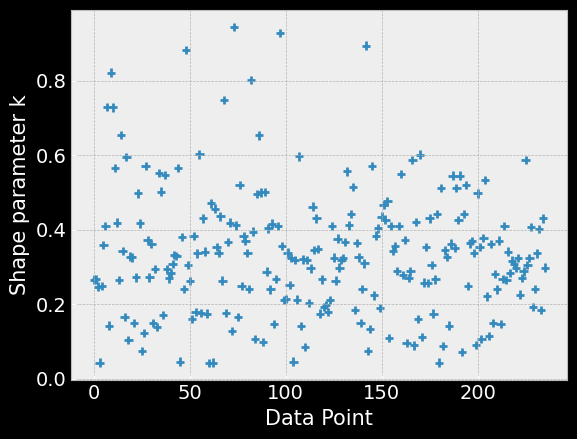

In [6]:
loo_res = az.loo(model.idata, pointwise=True)
print(loo_res)

# Visualize the k-hats
az.plot_khat(loo_res)
plt.show()

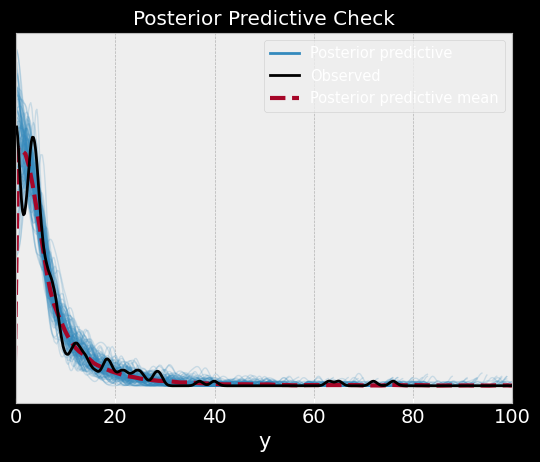

In [7]:

az.plot_ppc(model.idata, num_pp_samples=100)
plt.title("Posterior Predictive Check")
plt.xlim(0, 100)
plt.show()

In [8]:
pred = brms.posterior_predict(model)

In [ ]:

def get_brms_data(dataset_name: str, **kwargs) -> pd.DataFrame:
    """
    Load example dataset from brms package.
    
    Parameters
    ----------
    dataset_name : str
        Dataset name. Available datasets include:
        - 'epilepsy': Epileptic seizure counts
        - 'kidney': Kidney infection data with censoring
        - 'inhaler': Inhaler usage study
        - 'btdata': British Telecom share price data
        - And many more from brms package
    
    Returns
    -------
    pd.DataFrame
        Dataset as pandas DataFrame with column names preserved
    
    See Also
    --------
    brms::brmsdata : R documentation for available datasets
        https://paulbuerkner.com/brms/reference/index.html#data
    
    Examples
    --------
    Load epilepsy dataset:
    
    ```python
    from brmspy import brms
    epilepsy = brms.get_brms_data("epilepsy")
    print(epilepsy.head())
    print(epilepsy.columns)
    ```

    Load kidney dataset with censoring:
    
    ```python
    kidney = brms.get_brms_data("kidney")
    print(f"Shape: {kidney.shape}")
    print(f"Censored observations: {kidney['censored'].sum()}")
    ```
    """

    brms = get_brms()
    kwargs = kwargs_r(kwargs)
    with localconverter(default_converter + pandas2ri.converter + numpy2ri.converter) as cv:
        brmsdata = rpackages.data(brms, **kwargs)
        if brmsdata:
            return pd.DataFrame(brmsdata.fetch(dataset_name)[dataset_name])
        else:
            return pd.DataFrame({})

In [9]:
summary = brms.summary(model)
df_fixed = summary.fixed

print(df_fixed.to_string(index=True, justify="right", float_format="%.2f"))

[brmspy][iterate_robject_to_dataclass][WARNING] Type of param 'iter' <class 'int'> does not match expected '<class 'float'>'


            Estimate  Est.Error  l-95% CI  u-95% CI  Rhat  Bulk_ESS  Tail_ESS
Intercept       1.79       0.06      1.68      1.90  1.00   1119.45    983.44
zAge            0.10       0.04      0.02      0.18  1.00   1163.52    979.43
zBase           0.70       0.03      0.63      0.76  1.00    926.45    907.70
Trt1           -0.26       0.08     -0.41     -0.11  1.00   1065.05    980.16
zBase:Trt1      0.05       0.04     -0.02      0.14  1.00    948.40    940.45
